# Machine Learning for Classification<img align="right" src="image/gistda.png" width="200" height="200">

This is a case study to classify urban area by using Machine learning method.



<table class="ee-notebook-buttons" align="left">
    <td><a target="_parent"  href="https://nbviewer.org/github/Pathakorn40/rice-detection/blob/main/Tutorial/Machine_learning.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
</table>

### Imaport packages

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from odc.io.cgroups import get_cpu_quota
from sklearn import tree
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from dea_tools.classification import collect_training_data, predict_xr
from dream_river.plotimg import show_map, show_vector, geojson_add_Newcol 
from dream_river.geobox import merge, convert_geojson_CRS

from pystac_client import Client
from odc.stac import stac_load
import matplotlib.pyplot as plt

### Create training data (Draw polygons) 

The Drawing tool was used to create trianing data. This case study created 3 types of landuse to train the model that compose of water, urban and green.

In [3]:
Map =show_map()
Map

### Display output from drawing

In [4]:
# get path of files
path = ['training/green_area_sawan.geojson','training/water_sawan.geojson','training/urban_sawan.geojson']
show_vector(path)

### Data preparation

In [5]:
# open file in geopandas dataframe
gdf = gpd.read_file('training/urban_sawan.geojson')

# to see 5 first rows
gdf.head()

,class,geometry
0,111,"POLYGON ((100.13 15.705, 100.13 15.706, 100.13..."
1,111,"POLYGON ((100.14 15.707, 100.14 15.705, 100.14..."
2,111,"POLYGON ((100.14 15.706, 100.14 15.705, 100.14..."
3,111,"POLYGON ((100.15 15.713, 100.15 15.715, 100.15..."
4,111,"POLYGON ((100.15 15.718, 100.15 15.718, 100.15..."


#### - Add new column

In this case study, we create "class" in column name and add value into that column follow file name to categorize the type of data like: 

green_area = 111

water = 112

urban = 113

In [6]:
# func to add new colume and assign value
geojson_add_Newcol('training/urban_sawan.geojson')

num of rows:  18


18

In [7]:
# func to add new colume and assign value
geojson_add_Newcol('training/green_area_sawan.geojson')

num of rows:  20


20

In [8]:
# func to add new colume and assign value
geojson_add_Newcol('training/water_sawan.geojson')

num of rows:  14


14

#### - Explore new column

You will see new column was created

In [9]:
new_green = gpd.read_file('training/green_area_sawan.geojson')
new_green.head()

,class,,geometry
0,111,111,"POLYGON ((100.12 15.716, 100.12 15.717, 100.12..."
1,111,111,"POLYGON ((100.13 15.718, 100.13 15.719, 100.13..."
2,111,111,"POLYGON ((100.13 15.714, 100.13 15.714, 100.13..."
3,111,111,"POLYGON ((100.13 15.713, 100.14 15.713, 100.14..."
4,111,111,"POLYGON ((100.13 15.713, 100.13 15.713, 100.13..."


#### - Merge data 

The three geojson files was created follow above steps, We need to merge them together to train classification model.

In [10]:
# assige input path
file =['training/green_area_sawan.geojson','training/urban_sawan.geojson','training/water_sawan.geojson']

# assign output file path
output = 'training/model_training.geojson'

# merge function
merge(file,output)

#### - Explore merge output

In [11]:
merge_out = gpd.read_file('training/model_training.geojson')
merge_out.tail()

,class,,geometry
47,112,NaN,"POLYGON ((100.07 15.686, 100.07 15.687, 100.07..."
48,112,NaN,"POLYGON ((100.13 15.702, 100.13 15.704, 100.13..."
49,112,NaN,"POLYGON ((100.11 15.732, 100.11 15.733, 100.11..."
50,112,NaN,"POLYGON ((100.12 15.73, 100.12 15.73, 100.12 1..."
51,112,NaN,"POLYGON ((100.14 15.722, 100.14 15.724, 100.15..."


#### - Convert Geo Coodinate Refference System(CRS)

This case study have to convert the CRS from 4326 to 32647 to access the data cube of Gistda.

In [12]:
# check coordinate system of data
merge_out.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
# set input output path
input_path = 'training/model_training.geojson'
output_path = 'training/model_training32647.geojson'

# function to convert CRS
convert_geojson_CRS(input_path, output_path, crs=32647)

In [14]:
# explore output 
crs_out = gpd.read_file(output_path)
crs_out.crs

<Projected CRS: EPSG:32647>
Name: WGS 84 / UTM zone 47N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°E and 102°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Myanmar (Burma). Russian Federation. Thailand.
- bounds: (96.0, 0.0, 102.0, 84.0)
Coordinate Operation:
- name: UTM zone 47N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Extract training data using a shapefile

To train our model, we need to obtain satellite data that corresponds with the labelled input data locations above. 
The function below takes our shapefile containing class labels and extracts the specified product within these areas into a single array.

In [15]:
# Load input data shapefile
input_data = gpd.read_file('training/model_training32647.geojson')

# Plot first five rows
input_data.head()

,class,,geometry
0,111,111.0,"POLYGON ((6.2e+05 1.74e+06, 6.2e+05 1.74e+06, ..."
1,111,111.0,"POLYGON ((6.21e+05 1.74e+06, 6.21e+05 1.74e+06..."
2,111,111.0,"POLYGON ((6.21e+05 1.74e+06, 6.21e+05 1.74e+06..."
3,111,111.0,"POLYGON ((6.22e+05 1.74e+06, 6.22e+05 1.74e+06..."
4,111,111.0,"POLYGON ((6.22e+05 1.74e+06, 6.22e+05 1.74e+06..."


In [16]:
input_data.crs

<Projected CRS: EPSG:32647>
Name: WGS 84 / UTM zone 47N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°E and 102°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Myanmar (Burma). Russian Federation. Thailand.
- bounds: (96.0, 0.0, 102.0, 84.0)
Coordinate Operation:
- name: UTM zone 47N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
field = 'class'
time = ("2018-11-01","2018-11-10")
zonal_stats = 'median'
resolution = (-30, 30)
output_crs= "EPSG:32647"
ncpus=6

In [22]:
#set collection configuration
collections = ["LANDSAT8_SR_C2L2"]
config = {
    "LANDSAT8_SR_C2L2": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "unitless",
            },
            "aerosol_qa": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "bit",
            },
            "pixel_qa": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "bit",
            },
            "radsat_qa": {
                "data_type": "uint16",
                "units": "bit",
                "nodata": 0,
            },
        },
    }
}

In [23]:
# connect to the GISTDA ODC STAC Catalog
catalog = Client.open(url="http://110.78.252.138/stac")
query_training = catalog.search(
    bbox=(100.07376, 15.671872999999994, 100.152483, 15.732856999999997),collections=collections, datetime=f"{time[0]}/{time[1]}"
)
items_training = list(query_training.items())
print(f"Found: {len(items_training):d} datasets")
for ds in items_training:
    print(ds.to_dict()['properties']['title'])

Found: 1 datasets
LC08_L2SR_130049_20181103_20200830_02_T1


In [25]:
query = {
    "items": items_training,
    "bands": ['blue','green','red',"nir"],
    "stac_cfg":config,
    "chunks":{'time':2, 'x':200, 'y':200},
    "groupby":"solar_day"
}

The following function is passed to `collect_training_data`. 

It extracts bands from the [ls8_collections_sr_scene](https://datacube.gistda.or.th/explorer/products/ls8_collections_l1_scene) product as feature layers along side our labelled data so we can train a supervised model.

The feature function can be modified to extract different combinations of features within the datacube, it is one of the important parts to experiment with when generating your own model.

In [26]:
def custom_function(query):

    # Load data 
    result = stac_load(**query)
    
    return result.compute()


> **Note:** The following cell can take several minutes to run. The class labels will be contained in the first column of the output array called model_input, the corresponding variable names captured in the list column_names

In [27]:
column_names, model_input = collect_training_data(gdf=input_data,
                                                  dc_query=query,
                                                  ncpus=2,
                                                  feature_func=custom_function,
                                                  field=field,
                                                  zonal_stats=zonal_stats)

Taking zonal statistic: median


  0%|          | 0/52 [00:00<?, ?it/s]

Percentage of possible fails after run 1 = 3.85 %
Recollecting samples that failed


  0%|          | 0/2 [00:00<?, ?it/s]

Percentage of possible fails after run 2 = 3.85 %
Recollecting samples that failed


  0%|          | 0/2 [00:00<?, ?it/s]

Percentage of possible fails after run 3 = 3.85 %
Recollecting samples that failed


  0%|          | 0/2 [00:00<?, ?it/s]

Removed 2 rows wth NaNs &/or Infs
Output shape:  (50, 5)


### Preprocessing

Our training data has multiple classes in it.
However, we are only trying to predict one class (i.e. class label 111, _Urban area_) with this model. 
We therefore remove other classes from our training data by setting the label value for all other classes to 0.

These entries provide counter-examples to help the model distinguish the landcover classes from each other.

In [28]:
# Modify the input training data for single class labels
model_input[:, 0] = np.where(model_input[:, 0] == 113, 1, 0)

In [29]:
model_input[:, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Split to training data 70% and testing data 30%

So that we can access the accuracy of our classification, we split our data into training and testing data. 
70% is used for training with 30% held back for testing.
When splitting our data, we stratify the training data by the distributions of class membership.
This sampling method leads to a similar distribution of class membership in the training data.

In [30]:
# Split into training and testing data
model_train, model_test = model_selection.train_test_split(
    model_input, stratify=model_input[:, 0], train_size=0.7, random_state=0)
print("Train shape:", model_train.shape)
print("Test shape:", model_test.shape)

Train shape: (35, 5)
Test shape: (15, 5)


### Model preparation

This section automatically creates a list of variable names and their respective indices for each of the training data variables.

> **Note:** To use a custom subset of the satellite bands loaded above to train our data, you can replace `column_names[1:]` with a list of selected band names (e.g. `['red', 'green', 'blue']`)

The Decision Tree classification is a Machine learning method that was used in this case study. 

In [31]:
# Select the variables we want to use to train our model
model_variables = column_names[1:]

# Extract relevant indices from the processed shapefile
model_col_indices = [
    column_names.index(var_name) for var_name in model_variables
]

In [32]:
# Initialise model
model = tree.DecisionTreeClassifier(max_depth=10)

### Train model

The model is fitted / trained using the prepared training data. 
The fitting process uses the decision tree approach to create a generalized representation of reality based on the training data. 
This fitted / trained model can then be used to predict which class new data belongs to.

In [33]:
# Train model
model.fit(model_train[:, model_col_indices], model_train[:, 0])

DecisionTreeClassifier(max_depth=10)

#### - Predict with tesing data to validate the model

In [34]:
predictions = model.predict(model_test[:, model_col_indices])

#### - Accuracy of model

In [35]:
accuracy_score(predictions, model_test[:, 0])

0.9333333333333333

### Prediction

Now that we have a trained model, we can load new data and use the `predict_xr` function to predict landcover classes. 

The trained model can technically be used to classify any dataset or product with the same bands as the data originally used to train the data.
However, it is typically highly advisable to classify data from the same product that the data was originally trained on.


In [36]:
input_data2 = gpd.read_file('training/model_training32647.geojson')

In [37]:
shape = input_data2
    
# Compute the bounding box of the union of all geometries in shp
xmin, ymin, xmax, ymax = shape.unary_union.bounds
    
# Convert bounding box coordinates to decimal degrees
gdf_crs_decimal_degrees = shape.to_crs("EPSG:4326")
xmin, ymin = gdf_crs_decimal_degrees.total_bounds[:2]
xmax, ymax = gdf_crs_decimal_degrees.total_bounds[2:]

In [38]:
xmin, ymin, xmax, ymax 

(100.07376, 15.671872999999994, 100.152483, 15.732856999999997)

In [39]:
# Set up the query parameters
catalog = Client.open(url="http://110.78.252.138/stac")
search_query = catalog.search(
    bbox=[xmin, ymin, xmax, ymax], collections=collections, datetime=f"{time[0]}/{time[1]}"
)
items = list(search_query.items())
print(f"Found: {len(items):d} datasets")
for ds in items:
    print(ds.to_dict()['properties']['title'])

query = {
    "items": items,
    "bands": ['blue','green','red',"nir"],
    "stac_cfg":config,
    "chunks":{'time':2, 'x':200, 'y':200},
    "groupby":"solar_day",
    "bbox": [xmin, ymin, xmax, ymax]
}

# Use custom function to generate input data
input_data2 = custom_function(query)

Found: 1 datasets
LC08_L2SR_130049_20181103_20200830_02_T1


In [40]:
input_data2

<xarray.Dataset> Size: 522kB
Dimensions:      (y: 228, x: 284, time: 1)
Coordinates:
  * y            (y) float64 2kB 1.74e+06 1.74e+06 ... 1.733e+06 1.733e+06
  * x            (x) float64 2kB 6.15e+05 6.151e+05 ... 6.235e+05 6.235e+05
    spatial_ref  int32 4B 32647
  * time         (time) datetime64[ns] 8B 2018-11-03T03:43:28
Data variables:
    blue         (time, y, x) uint16 130kB 8023 8225 8406 ... 9003 9211 9402
    green        (time, y, x) uint16 130kB 8872 9052 9298 ... 9913 10188 10366
    red          (time, y, x) uint16 130kB 8310 8594 8807 ... 10222 10508 10848
    nir          (time, y, x) uint16 130kB 19426 18808 18386 ... 16632 17248

#### - Predict 

In [41]:
# Predict landcover using the trained model
predicted = predict_xr(model, input_data2, clean=True)
print(predicted.Predictions)

predicting...
<xarray.DataArray 'Predictions' (y: 228, x: 284)> Size: 518kB
array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.]])
Coordinates:
  * x            (x) float64 2kB 6.15e+05 6.151e+05 ... 6.235e+05 6.235e+05
  * y            (y) float64 2kB 1.74e+06 1.74e+06 ... 1.733e+06 1.733e+06
    spatial_ref  int32 4B 32647
Attributes:
    grid_mapping:  spatial_ref


#### Plot output

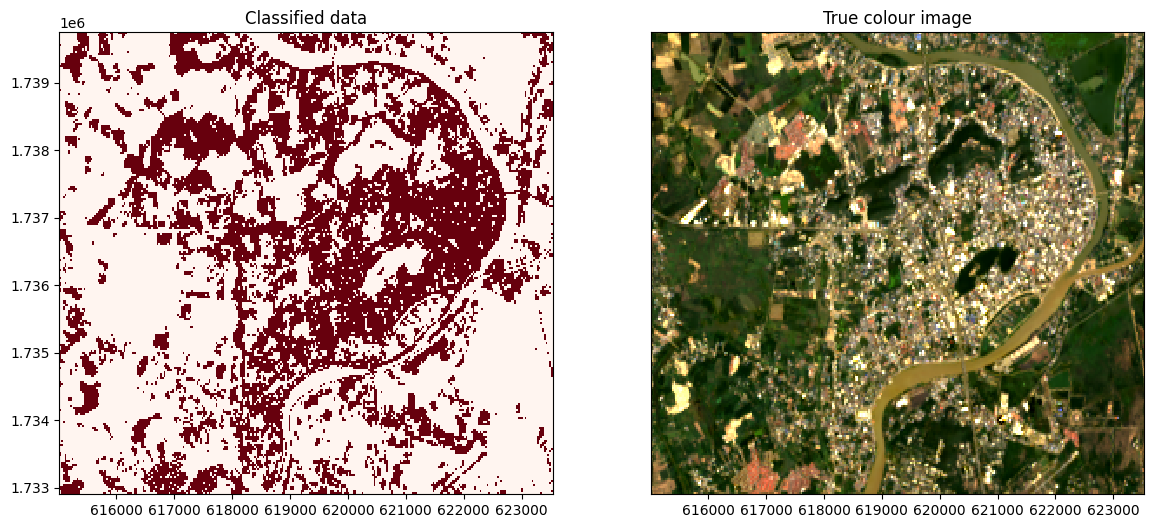

In [42]:
# Set up plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot classified image
predicted.Predictions.plot(ax=axes[0], 
               cmap='Reds', 
               add_labels=False, 
               add_colorbar=False)

# Plot true colour image
(input_data2[['red', 'green', 'blue']]
 .squeeze('time')
 .to_array()
 .plot.imshow(ax=axes[1], robust=True, add_labels=False))

# Remove axis on right plot
axes[1].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('Classified data')
axes[1].set_title('True colour image');